In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn import grid_search, cross_validation
from sklearn import linear_model, metrics


%matplotlib inline

## Reading Data for Principle Strips, Reindex based on date and maturity of the bond, and using values of OAD, Yield, Return and MV to be columns

In [115]:
dfOAD= pd.read_csv("~/homework/GS-homework/data/POAD.csv")

In [116]:
dfOAD['Date']=pd.to_datetime(dfOAD['Date'])
dfOAD.set_index(['Date'],drop=True,inplace=True)

In [117]:
x=dfOAD
y=x.stack()
y=y.to_frame()
y.columns.names=["Maturity"]
y = y.rename(columns= {0: 'OAD'})

In [118]:
dfYield= pd.read_csv("~/homework/GS-homework/data/PYield.csv")
dfYield['Date']=pd.to_datetime(dfYield['Date'])
dfYield.set_index(['Date'],drop=True,inplace=True)

x1 = dfYield
y1=x1.stack()
y1=y1.to_frame()
y1.columns.names=["Maturity"]
y1 = y1.rename(columns= {0: 'Yield'})

In [119]:
dfReturn= pd.read_csv("~/homework/GS-homework/data/PReturn.csv")
dfReturn['Date']=pd.to_datetime(dfReturn['Date'])
dfReturn.set_index(['Date'],drop=True,inplace=True)

x2 = dfReturn
y2=x2.stack()
y2=y2.to_frame()
y2.columns.names=["Maturity"]
y2 = y2.rename(columns= {0: 'Return'})

In [120]:
dfMV= pd.read_csv('~/homework/GS-homework/data/PMV.csv')
dfMV['Date']=pd.to_datetime(dfMV['Date'])
dfMV.set_index(['Date'],drop=True,inplace=True)

x3 = dfMV
y3=x3.stack()
y3=y3.to_frame()
y3.columns.names=["Maturity"]
y3 = y3.rename(columns= {0: 'MarketValue'})

In [121]:
frames=[y1,y]

#print(frames)
data1=pd.concat(frames, keys=["Date","Maturity"],axis=1)

frames=[y2,y3]

#print(frames)
data2=pd.concat(frames, keys=["Date","Maturity"],axis=1)

frames=[data1,data2]

data=pd.concat(frames, keys=["Date","Maturity"],axis=1)

In [122]:
data1=pd.DataFrame(data.values)
data1.columns=["Yield","OAD","Return","MarketValue"]
data1.index=data.index

In [123]:
print(data1)

                  Yield    OAD  Return  MarketValue
Date                                               
1998-12-31 15.75  5.216  10.60    0.45    1764845.0
           16     5.336  15.70   -0.01     685366.0
           16.5   5.456  16.18    0.47      72978.0
           16.75  5.536  16.42    0.98     429867.0
           17     5.586  16.66    1.65      32703.0
           17.25  5.566  16.90    1.51     100806.0
           17.75  5.586  17.38    1.54     367543.0
           18.25  5.596  17.87    1.21    3578758.0
           18.5   5.596  18.12    1.39    1828482.0
           19.25  5.619  18.84    1.57    2098649.0
           19.75  5.619  19.33    1.60    2315149.0
           20     5.629  19.57    1.81    4691429.0
           20.5   5.619  20.06    1.84     482119.0
           21     5.619  20.55    1.67    1401298.0
           21.25  5.619  20.79    1.69    2365409.0
           21.5   5.619  21.03    1.91    4839607.0
           22     5.599  21.52    1.72     312678.0
           2

#### Calculate RollDownReturns Using (Yield1-Yield2)/(Maturity1-Maurity2)*OAD1

In [124]:
def RollDownReturn(x,y,z):
    r=[]

    for i in range(1,len(x)-2,1):
        max_x = float(x[-i])
        lag_x = float(x[-i-3])
        diff_x = max_x - lag_x
    
        max_y = float(y[-i])
        lag_y = float(y[-i-3])
        diff_y = max_y - lag_y
    
        oad_max = float(z[-i])

        r.append(diff_y/diff_x*oad_max)
    
    #The third row
    max_x=float(x[-len(x)+2])
    lag_x=float(x[-len(x)])
    diff_x=max_x-lag_x
    
    max_y=float(y[-len(x)+2])
    lag_y=float(y[-len(x)])
    diff_y=max_y-lag_y
    
    oad_max = float(z[-len(x)+2])
    
    r.append(diff_y/diff_x*oad_max)
    
    #The second row
    max_x=float(x[-len(x)+1])
    lag_x=float(x[-len(x)])
    diff_x=max_x-lag_x
    
    max_y=float(y[-len(x)+1])
    lag_y=float(y[-len(x)])
    diff_y=max_y-lag_y
    
    oad_max = float(z[-len(x)+1])
    
    r.append(diff_y/diff_x*oad_max)
    
    r.append(0)
    r=r[::-1]
    return r

#### Calculate each bond's return versus average return of within same month, add both rolldown return and relative return fields

In [125]:
FinalDF=pd.DataFrame(columns=['Yield','OAD','Return','MarketValue','RollDown','ReturnVsAvg','Date'])
DateSet=data1.index.get_level_values('Date').unique()
for D in DateSet:
    test = data1.xs(D,level="Date")
    #print (len(RollDownReturn(test.index,test["Yield"],test["OAD"])))
    test['RollDown']=RollDownReturn(test.index,test["Yield"],test["OAD"])
    test['ReturnVsAvg']=test['Return']-test['Return'].mean()
    test['Date']=D
    FinalDF=FinalDF.append(test)
print(FinalDF.head())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

       Yield    OAD  Return  MarketValue  RollDown  ReturnVsAvg       Date
15.75  5.216  10.60    0.45    1764845.0    0.0000    -1.412857 1998-12-31
16     5.336  15.70   -0.01     685366.0    7.5360    -1.872857 1998-12-31
16.5   5.456  16.18    0.47      72978.0    5.1776    -1.392857 1998-12-31
16.75  5.536  16.42    0.98     429867.0    5.2544    -0.882857 1998-12-31
17     5.586  16.66    1.65      32703.0    4.1650    -0.212857 1998-12-31


In [126]:
FinalDF.columns.names=["Maturity"]
FinalDF.set_index(['Date'], append=True)
print(FinalDF.head())

Maturity  Yield    OAD  Return  MarketValue  RollDown  ReturnVsAvg       Date
15.75     5.216  10.60    0.45    1764845.0    0.0000    -1.412857 1998-12-31
16        5.336  15.70   -0.01     685366.0    7.5360    -1.872857 1998-12-31
16.5      5.456  16.18    0.47      72978.0    5.1776    -1.392857 1998-12-31
16.75     5.536  16.42    0.98     429867.0    5.2544    -0.882857 1998-12-31
17        5.586  16.66    1.65      32703.0    4.1650    -0.212857 1998-12-31


In [66]:
FinalDF.describe()

Maturity,Yield,OAD,Return,MarketValue,RollDown,ReturnVsAvg
count,6603.000000,6603.000000,6603.000000,6.601000e+03,6603.000000,6.603000e+03
mean,4.416512,23.561266,0.718455,1.817173e+06,0.231100,2.918896e-17
std,1.261037,4.844823,5.241959,1.600606e+06,1.152736,1.176066e+00
min,1.775000,10.410000,-24.540000,0.000000e+00,-11.404000,-1.211769e+01
25%,3.108000,19.355000,-2.520000,6.926560e+05,-0.323983,-3.732125e-01
50%,4.625000,23.690000,0.750000,1.394685e+06,0.257440,-8.333333e-04
75%,5.540500,27.620000,3.805000,2.343275e+06,0.883248,3.518750e-01
max,6.944000,33.700000,36.450000,9.937794e+06,9.372000,1.377950e+01


#### Plot Return and Rolldown Return distribution

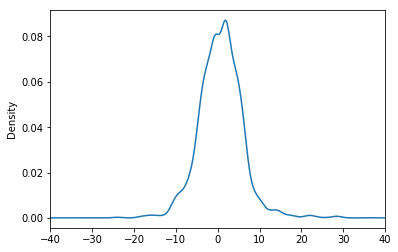

In [67]:
#plot the distribution of each variable 
FinalDF['Return'].plot(kind="density",xlim=(-40,40))

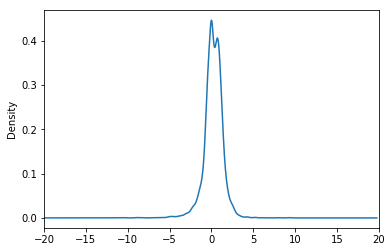

In [68]:
FinalDF['RollDown'].plot(kind="density",xlim=(-20,20))

#### Calculate Correlation and Skewness, Kurtness of the rolldown return

In [69]:
FinalDF['ReturnVsAvg'].corr(FinalDF['RollDown'])

0.07198220401168177

In [70]:
FinalDF['RollDown'].skew()

-1.17781135963977

In [71]:
FinalDF['RollDown'].kurt()

12.40467752486392

## Repeat same process on coupon strips

In [72]:
dfSOAD= pd.read_csv("~/homework/GS-homework/data/SOAD.csv")
dfSOAD['Date']=pd.to_datetime(dfSOAD['Date'])
dfSOAD.set_index(['Date'],drop=True,inplace=True)

In [99]:
x=dfSOAD
y=x.stack()
y=y.to_frame()
y.columns.names=["Maturity"]
y = y.rename(columns= {0: 'OAD'})

In [100]:
dfSYield= pd.read_csv("~/homework/GS-homework/data/SYield.csv")
dfSYield['Date']=pd.to_datetime(dfSYield['Date'])
dfSYield.set_index(['Date'],drop=True,inplace=True)

x1 = dfSYield
y1=x1.stack()
y1=y1.to_frame()
y1.columns.names=["Maturity"]
y1 = y1.rename(columns= {0: 'Yield'})

In [101]:
dfSReturn= pd.read_csv("~/homework/GS-homework/data/SReturn.csv")
dfSReturn['Date']=pd.to_datetime(dfSReturn['Date'])
dfSReturn.set_index(['Date'],drop=True,inplace=True)

x2 = dfSReturn
y2=x2.stack()
y2=y2.to_frame()
y2.columns.names=["Maturity"]
y2 = y2.rename(columns= {0: 'Return'})

In [102]:
dfSMV= pd.read_csv('~/homework/GS-homework/data/SMV.csv')
dfSMV['Date']=pd.to_datetime(dfSMV['Date'])
dfSMV.set_index(['Date'],drop=True,inplace=True)

x3 = dfSMV
y3=x3.stack()
y3=y3.to_frame()
y3.columns.names=["Maturity"]
y3 = y3.rename(columns= {0: 'MarketValue'})

In [103]:
frames=[y1,y]

dataS1=pd.concat(frames, keys=["Date","Maturity"],axis=1)

frames=[y2,y3]

dataS2=pd.concat(frames, keys=["Date","Maturity"],axis=1)

frames=[dataS1,dataS2]

dataS=pd.concat(frames, keys=["Date","Maturity"],axis=1)

In [104]:
dataSF=pd.DataFrame(dataS.values)
dataSF.columns=["Yield","OAD","Return","MarketValue"]
dataSF.index=dataS.index

In [105]:
print(dataSF)

                  Yield    OAD  Return  MarketValue
Date                                               
1998-12-31 15     5.496  14.72    1.36    1398081.0
           15.25  5.516  14.96    1.38    1479603.0
           15.5   5.526  15.20    1.39    1354497.0
           15.75  5.536  15.44    1.41    1435450.0
           16     5.546  15.69    1.26    1313949.0
           16.25  5.566  15.93    1.45    1316255.0
           16.5   5.576  16.17    1.29    1236189.0
           16.75  5.586  16.41    1.15    1276419.0
           17     5.596  16.66    1.15    1194972.0
           17.25  5.606  16.90    1.34    1217137.0
           17.5   5.606  17.14    1.17    1158989.0
           17.75  5.616  17.38    1.37    1178370.0
           18     5.626  17.63    1.37    1123421.0
           18.25  5.626  17.87    1.39    1130826.0
           18.5   5.626  18.11    1.40    1092684.0
           18.75  5.626  18.35    1.42     948414.0
           19.25  5.629  18.84    1.58     921944.0
           1

In [127]:
FinalDF_S=pd.DataFrame(columns=['Yield','OAD','Return','MarketValue','RollDown','ReturnVsAvg','OADadjRet','Date'])
DateSet_S=dataSF.index.get_level_values('Date').unique()
for D in DateSet_S:
    test = dataSF.xs(D,level="Date")
    test['RollDown']=RollDownReturn(test.index,test["Yield"],test["OAD"])
    test['OADadjRet']=test['Return']/test['OAD']
    test['ReturnVsAvg']=test['OADadjRet']-test['OADadjRet'].mean()
    test['Date']=D
    FinalDF_S=FinalDF_S.append(test)
print(FinalDF_S.head())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

            Date  MarketValue    OAD  OADadjRet  Return  ReturnVsAvg  \
15    1998-12-31    1398081.0  14.72   0.092391    1.36    -0.004426   
15.25 1998-12-31    1479603.0  14.96   0.092246    1.38    -0.004571   
15.5  1998-12-31    1354497.0  15.20   0.091447    1.39    -0.005370   
15.75 1998-12-31    1435450.0  15.44   0.091321    1.41    -0.005496   
16    1998-12-31    1313949.0  15.69   0.080306    1.26    -0.016511   

       RollDown  Yield  
15     0.000000  5.496  
15.25  1.196800  5.516  
15.5   0.912000  5.526  
15.75  0.823467  5.536  
16     0.627600  5.546  


In [128]:
FinalDF_S.columns.names=["Maturity"]
FinalDF_S.set_index(['Date'], append=True)
print(FinalDF_S.head())

Maturity       Date  MarketValue    OAD  OADadjRet  Return  ReturnVsAvg  \
15       1998-12-31    1398081.0  14.72   0.092391    1.36    -0.004426   
15.25    1998-12-31    1479603.0  14.96   0.092246    1.38    -0.004571   
15.5     1998-12-31    1354497.0  15.20   0.091447    1.39    -0.005370   
15.75    1998-12-31    1435450.0  15.44   0.091321    1.41    -0.005496   
16       1998-12-31    1313949.0  15.69   0.080306    1.26    -0.016511   

Maturity  RollDown  Yield  
15        0.000000  5.496  
15.25     1.196800  5.516  
15.5      0.912000  5.526  
15.75     0.823467  5.536  
16        0.627600  5.546  


In [129]:
FinalDF_S.describe()

Maturity,MarketValue,OAD,OADadjRet,Return,ReturnVsAvg,RollDown,Yield
count,1.267500e+04,12675.000000,12675.000000,12675.000000,1.267500e+04,12675.000000,12675.000000
mean,4.495431e+05,22.664312,0.033386,0.736404,2.373731e-18,0.129990,4.410730
std,3.373483e+05,4.332160,0.233669,5.360594,3.791072e-02,0.941097,1.204879
min,0.000000e+00,14.430000,-0.986994,-26.730000,-4.082798e-01,-12.807500,1.876000
25%,1.398695e+05,19.030000,-0.115391,-2.590000,-1.475098e-02,-0.288187,3.186500
50%,4.054250e+05,22.530000,0.030157,0.630000,1.434164e-04,0.252653,4.609000
75%,7.128240e+05,26.065000,0.171726,3.770000,1.383370e-02,0.689887,5.379000
max,1.486540e+06,33.700000,1.425418,29.430000,3.757267e-01,5.188480,6.954000


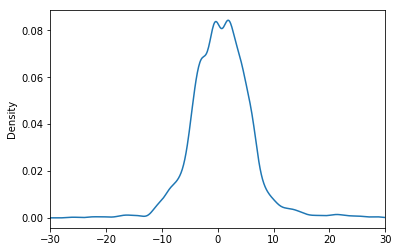

In [110]:
FinalDF_S['Return'].plot(kind="density",xlim=(-30,30))

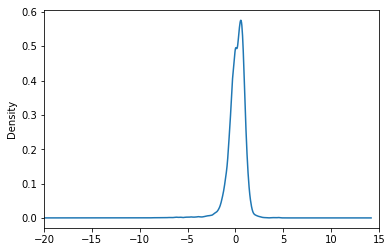

In [112]:
FinalDF_S['RollDown'].plot(kind="density",xlim=(-20,15))

In [130]:
FinalDF_S['ReturnVsAvg'].corr(FinalDF_S['RollDown'])

0.1458400338696924

In [114]:
print(FinalDF_S['RollDown'].skew())
print(FinalDF_S['RollDown'].kurt())

-2.7835745253029387
20.315305234645674


## So the next step of the analysis is to find the relationship of rolldown return versus actual return of the subsequent month.
Based on above data, I can see they are slightly positive correlated.